In [347]:
import numpy as np
from matplotlib import pyplot as plt

def trilateration_3d(P1, P2, P3, d1, d2, d3):
    # Convert points to numpy arrays
    P1 = np.array(P1)
    P2 = np.array(P2)
    P3 = np.array(P3)

    # Unit vector in direction from P1 to P2
    ex = (P2 - P1)
    ex = ex / np.linalg.norm(ex)

    # Vector from P1 to P3
    P3_P1 = P3 - P1

    # Project P3_P1 onto ex to find i
    i = np.dot(ex, P3_P1)

    # Vector in the P1-P3 plane orthogonal to ex
    temp = P3_P1 - i * ex
    ey = temp / np.linalg.norm(temp)

    # ez is the cross product of ex and ey
    ez = np.cross(ex, ey)

    # Coordinates in new basis
    d = np.linalg.norm(P2 - P1)
    j = np.dot(ey, P3_P1)

    # Coordinates of drone in local coordinate system
    x = (d1**2 - d2**2 + d**2) / (2 * d)
    y = (d1**2 - d3**2 + i**2 + j**2 - 2 * i * x) / (2 * j)

    # Calculate z coordinate
    z_sq = d1**2 - x**2 - y**2
    if z_sq < 0:
        z_sq = 0
    z = np.sqrt(z_sq)

    # Convert back to original coordinate system
    coordinates = P1 + x * ex + y * ey + z * ez
    return coordinates

from scipy.optimize import least_squares

def trilateration_least_squares(beacons, distances):
    def residuals(pos):
        return [np.linalg.norm(pos - beacon) - dist for beacon, dist in zip(beacons, distances)]
    
    # Initial guess: centroid of beacons
    x0 = np.mean(beacons, axis=0)
    
    result = least_squares(residuals, x0)
    return result.x

In [348]:
P1 = np.array([0.0, 0.0, 0.0])
P2 = np.array([0.0, .5, 0.0])
P3 = np.array([.8963, .412, 0.0])
beacons = np.array([P1,P2,P3])
data = np.load('lake_circle.npz')
distance1, distance2, distance3, t1, t2, t3 = data['d1'].astype(float),data['d2'].astype(float),data['d3'].astype(float),data['t1'],data['t2'],data['t3']

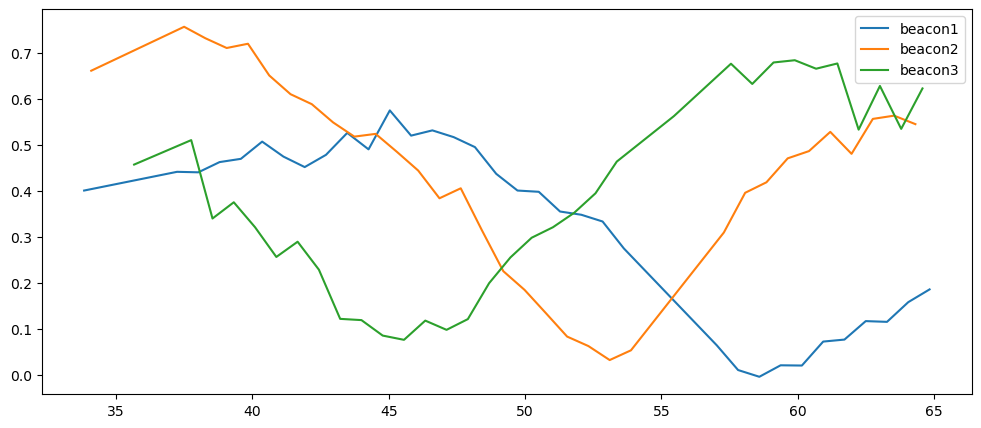

In [349]:
def read_range_and_beacon_id(buf_idx):
    pre_idx = 3.0
    tmsp_ping_rx = pre_idx * 18000.0 + buf_idx
    dt = tmsp_ping_rx/1.38e6
    distance = 0.5 * dt * 1500.0 - 30.012
    return distance
def process_data(dis):
    for i in range(len(dis)):
        dis[i] = read_range_and_beacon_id(float(dis[i]))
    return dis
distance1=process_data(distance1)
distance2=process_data(distance2)
distance3=process_data(distance3)
plt.figure(figsize=(12,5))
plt.plot(t1/1000,distance1,label='beacon1')
plt.plot(t2/1000,distance2,label='beacon2')
plt.plot(t3/1000,distance3,label='beacon3')
plt.legend()
plt.show()
#plt.ylim(0.18, 0.2)
#plt.ylim(0.25, 0.28)
#plt.ylim(0.2, 0.3)

In [350]:
L = min(len(distance1),len(distance2),len(distance3))
Trilater_drone_path = np.zeros((L,3))
for i in range(L):
    Trilater_drone_path[i,:] = trilateration_least_squares(beacons,np.array([distance1[i], distance2[i], distance3[i]]))

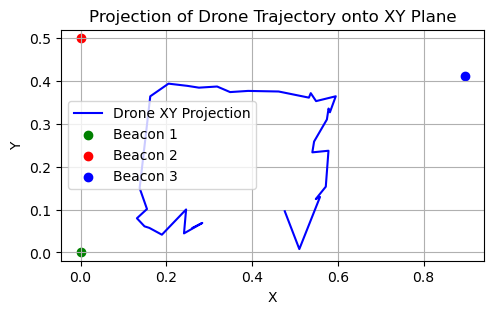

In [351]:
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.plot(Trilater_drone_path[:,0], Trilater_drone_path[:,1], label='Drone XY Projection', color='blue')
plt.scatter(P1[0], P1[1], c='green', label='Beacon 1')
plt.scatter(P2[0], P2[1], c='red', label='Beacon 2')
plt.scatter(P3[0], P3[1], c='blue', label='Beacon 3')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Projection of Drone Trajectory onto XY Plane")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.show()

In [352]:
import plotly.graph_objects as go
import numpy as np

# Create plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=Trilater_drone_path[:,0], y=Trilater_drone_path[:,1], z=Trilater_drone_path[:,2],
    mode='lines',
    name='Drone Path',
    line=dict(color='blue')
))
beacons=np.array([P1,P2,P3])
fig.add_trace(go.Scatter3d(
    x=beacons[:,0], y=beacons[:,1], z=beacons[:,2],
    mode='markers',
    name='Beacons',
    marker=dict(size=5, color=['green','red','blue'])
))

fig.update_layout(
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    title='Interactive 3D Drone Trajectory',
    width=800,
    height=600,

)

fig.show()


C:\Users\brian\AppData\Local\Temp\ipykernel_21472\3107463644.py:17: UserWarning:

Attempting to set identical low and high zlims makes transformation singular; automatically expanding.



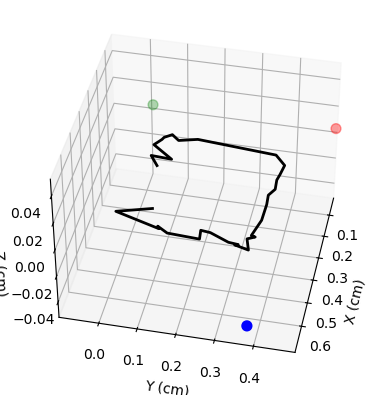

In [353]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from IPython.display import HTML
import matplotlib.image as mpimg

Trilater_drone_path[:, 2]=0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(beacons[:,0], beacons[:,1], beacons[:,2], c=['green','red','blue'], s=50, label='Beacons')
line, = ax.plot([], [], [], lw=2, color='black')
point, = ax.plot([], [], [], 'ko')  # red point for the beacon

# Set axis limits
ax.set_xlim(np.min(Trilater_drone_path[:,0])-0.1, np.max(Trilater_drone_path[:,0])+0.1)
ax.set_ylim(np.min(Trilater_drone_path[:,1])-0.1, np.max(Trilater_drone_path[:,1])+0.1)
ax.set_zlim(np.min(Trilater_drone_path[:,2]), np.max(Trilater_drone_path[:,2]))
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=40, azim=12)
def update(frame):
    line.set_data(Trilater_drone_path[:frame, 0], Trilater_drone_path[:frame, 1])
    line.set_3d_properties(Trilater_drone_path[:frame, 2])

    return line, point

ani = FuncAnimation(fig, update, frames=len(t2), interval=50, blit=True)
HTML(ani.to_jshtml())

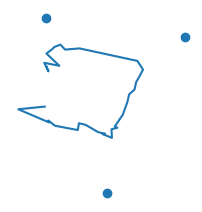

(33, 2)
(3, 2)


In [403]:
from numpy import sin,cos,pi
from scipy.linalg import norm

azim = 12*pi/180
elev = 40*pi/180
a_vec = np.array([cos(azim),sin(azim),0])
normal = cos(elev)*a_vec + np.array([0,0,sin(elev)])
z_vec = np.array([0,0,1])
y_comp = z_vec - (z_vec@normal)*normal
y_comp = y_comp/norm(y_comp)
x_comp = np.cross(y_comp,normal)
proj_mat = np.vstack([x_comp,y_comp]) # build projection matrix
proj_mat = -proj_mat                  # account for flipped axes
points_2D = Trilater_drone_path @ proj_mat.T       # apply projection
minor_2D = beacons @ proj_mat.T       # apply projection
plt.figure(figsize=(3,2.5))
plt.plot(*points_2D.T)
plt.scatter(*minor_2D.T)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()
print(points_2D.shape)
print(minor_2D.shape)

In [ ]:
import cv2
import numpy as np
t3 = t3-t3.min()+1000
tmax = t3.max()
print(tmax)
points_2D -= points_2D.min()
max = points_2D.max()
points_2D = points_2D*500/max

minor_2D -= minor_2D.min()
max = minor_2D.max()
minor_2D = minor_2D*700/max

def process_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {input_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    nframes = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    iframe = 0
    i_coord = 0
    update_frame = t3[0]*nframes/tmax
    print(nframes)
    while 1:
        ret, frame = cap.read()
        cv2.circle(frame, (550-points_2D[i_coord][0].astype(int), -150+points_2D[i_coord][1].astype(int)), 20, (255, 255, 255), 3)
        cv2.circle(frame, (650-minor_2D[0,0].astype(int), -190+minor_2D[0,1].astype(int)), 20, (0, 255, 0), 3)
        cv2.circle(frame, (650-minor_2D[1,0].astype(int), -190+minor_2D[1,1].astype(int)), 20, (0, 0, 255), 3)
        cv2.circle(frame, (650-minor_2D[2,0].astype(int), -190+minor_2D[2,1].astype(int)), 20, (255, 0, 0), 3)
        out.write(frame)
        iframe += 1
        if not ret:
            break
        if iframe > update_frame and i_coord<len(t3)-1:
            i_coord += 1
            update_frame = t3[i_coord]*nframes/tmax
    cap.release()
    out.release()
    cv2.destroyAllWindows()
input_video_path = "exp.mp4"
output_video_path = "trim.mp4"
process_video(input_video_path, output_video_path)

35879.26991991699
887.0
